In [1]:
### import statements and dataset initialization ###
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import collections
import numpy as np
from scipy import signal
from itertools import islice
from collections import defaultdict
from countryinfo import CountryInfo
from dateutil import relativedelta
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import plotly.io as pio

In [3]:
def read_multiple_files(fields, filename_template):
    '''
    provide the file names to read in and the columns to read
    :param fields: the columns we want
    :type fields: list
    :param filename_template: file names we want to read
    :type filename_template: str

    :returns: pandas df
    '''
    assert isinstance(fields, list)
    assert isinstance(filename_template, str)
    filenames = []
    for i in range(1, 25):
        filenames.append(filename_template.format(i))

    df_from_each_file = (pd.read_csv(f, usecols=fields) for f in filenames)
    df = pd.concat(df_from_each_file, ignore_index=True)
    
    ### standardizing the time column to just date without time ###
    df["day"] = df["day"].apply(lambda x: datetime.datetime.strptime(x.split()[0], '%Y-%m-%d'))
    
    return df

In [4]:
df = read_multiple_files(['origin', 'destination', 'day'], 'flightlist_{}.csv.gz')

In [7]:
def label_flights(row):
    '''
    Given a row from the flights dataframe, will return if that flight was domestic or not
    :param row: the pandas df row
    :type row: pd.Series

    :returns: boolean
    '''
    try:
        return airport_dict[row['origin']] == airport_dict[row['destination']]
    except:
        return False

In [8]:
def import_clean_airport_codes(fields):
    '''
    Import and clean airport codes data
    :param fields: the columns we want to read from csv
    :type fields: list

    :returns: pandas df with cleaned airport codes
    '''
    assert isinstance(fields, list, "input not a list")
    fields = ['ident', 'name', 'continent', 'iso_country']
    airport_codes = pd.read_csv('Data/airport-codes.csv', usecols=fields)
    airport_codes.set_index('ident', inplace = True)

    df_drop_na = df.dropna()
    airport_dict = {}
    for index, row in airport_codes.iterrows():
        airport_dict[index] = row['iso_country']

    return airport_codes

In [11]:
df_drop_na = df.dropna()
df_drop_na['domestic'] = df_drop_na.apply(lambda row: label_flights(row), axis=1)

<ipython-input-11-44e4349490d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_na['domestic'] = df_drop_na.apply(lambda row: label_flights(row), axis=1)


In [12]:
def count_domestic_flights(df):
    '''
    Count domestic flights by day in 2019 and 2020
    :param df: The dataframe containing domestic column
    :type df: Pandas Dataframe

    :returns: returns dictionary mapping day to number of domestic flights
    '''
    assert isinstance(df, pd.DataFrame)
    domestic_flights = defaultdict(int)
    international_flights = defaultdict(int)
    for index, row in df_drop_na.iterrows():
        domestic_flights[row['day']] += row['domestic'] == True
        international_flights[row['day']] += row['domestic'] == False

    ordered_domestic = collections.OrderedDict(sorted(domestic_flights.items()))

    # Using items() + len() + slice()
    # Split dictionary by half
    inc = iter(ordered_domestic.items())
    res1 = dict(islice(inc, 364))
    res2 = dict(inc)

    domestic_2019 = defaultdict(int)
    domestic_2020 = defaultdict(int)
    for key, value in res1.items():
        domestic_2019[str(key.month)] += value
    for key, value in res2.items():
        domestic_2020[str(key.month)] += value

    ordered_non_domestic = collections.OrderedDict(sorted(international_flights.items()))

    # Using items() + len() + slice()
    # Split dictionary by half
    inc = iter(ordered_non_domestic.items())
    res1 = dict(islice(inc, 364))
    res2 = dict(inc)

    international_2019 = defaultdict(int)
    international_2020 = defaultdict(int)
    for key, value in res1.items():
        international_2019[str(key.month)] += value
    for key, value in res2.items():
        international_2020[str(key.month)] += value

    months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
                6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 1: 'Nov', 12: 'Dec'}
    data = {'2019 domestic': domestic_2019, '2020 domestic': domestic_2020, '2019 international': international_2019,
            '2020 international': international_2020, "month": months}
    domestic_international_df = pd.DataFrame.from_dict(data)

    return domestic_international_df

In [30]:
df = count_domestic_flights(df)

In [40]:
def generate_2019_domestic_chart(domestic_international_df):
    '''
    The dataframe containing the domestic labels
    :param domestic_international_df: a pandas Dataframe containing all data
    :type domestic_international_df: pd.Dataframe

    :returns: Generates a plot for 2019
    '''
    fig = px.bar(domestic_international_df, x=domestic_international_df.index, y=['2019 Domestic', '2019 International'], range_y = (0,1500000), barmode='group',
                                 labels={
                         "index": "Month",
                         "value": "Number of Flights",
                     },
                    title="Domestic vs International Flights in 2019")
    fig.update_layout(
        legend_title_text= '',
        xaxis = dict(
            tickmode = 'array',
            tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            ticktext = ['Jan','Feb', 'Mar', 'Apr','May',
                'Jun', 'Jul','Aug', 'Sep',  'Oct', 'Nov',  'Dec']
        )
    )
    fig.show()

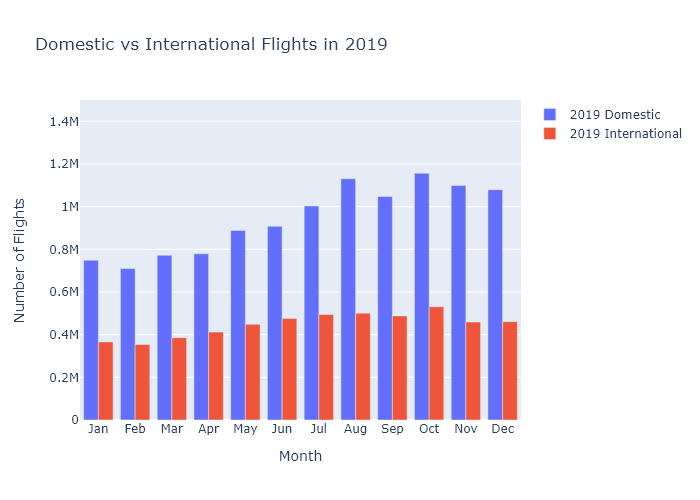

In [41]:
generate_2019_domestic_chart(df)

In [44]:
def generate_2020_domestic_chart(domestic_international_df):
    '''
    The dataframe containing the domestic labels
    :param domestic_international_df: a pandas Dataframe containing all data
    :type domestic_international_df: pd.Dataframe

    :returns: Generates a plot for 2020
    '''
    fig = px.bar(domestic_international_df, x=domestic_international_df.index, y=['2020 Domestic', '2020 International'], range_y = (0,1500000), barmode='group',
                                              labels={
                         "index": "Month",
                         "value": "Number of Flights",

                     },
                    title="Domestic vs International Flights in 2020")
    fig.update_layout(
        legend_title_text= '',
        xaxis = dict(
            tickmode = 'array',
            tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            ticktext = ['Jan','Feb', 'Mar', 'Apr','May',
                'Jun', 'Jul','Aug', 'Sep',  'Oct', 'Nov',  'Dec']

        )
    )
    fig.show()

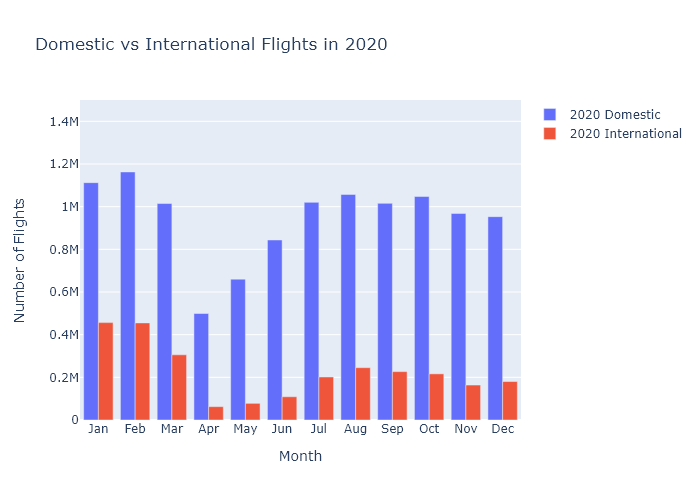

In [45]:
generate_2020_domestic_chart(df)

In [13]:
def add_country_names(row):
    '''
    Given a row from the flight dataset, will return the destination country name
    :param row: A row from the dataframe
    :type row: pd.Series

    :returns: Eitther the name of the destination country, or None if it's unknown
    '''
    try:
        return airport_dict[row['destination']]
    except:
        return None

In [16]:
df_drop_na['country'] = df_drop_na.apply(lambda row: add_country_names(row), axis=1)

<ipython-input-16-5c5c7ea0cacc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_na['country'] = df_drop_na.apply(lambda row: add_country_names(row), axis=1)


In [17]:
def count_arrivals_by_country(df):
    '''
    The dataframe containing country names
    :param df: a pandas Dataframe containing all data
    :type df: pd.Dataframe

    :returns: Generates number of arrivals by country
    '''
    country_arrivals = defaultdict(lambda: defaultdict(int))
    for index, row in df_drop_na.iterrows():
        country_arrivals[row['day']][row['country']] += 1

    arrivals = collections.OrderedDict(sorted(country_arrivals.items()))
    return arrivals

In [23]:
arrivals = count_arrivals_by_country(df_drop_na)

In [18]:
def count_US_Korea_covid_cases(date, arrivals):
    '''
    Given a date and the arrivals dictionary, produces what percent of US/Korea flew and the cases
    :param date: date string
    :type date: str
    :param arrivals: dictionary containing country arrival frequencies
    :type arrivals: dict

    :returns: Generate data for Korea vs US map
    '''
    first = datetime.datetime.strptime(date, '%Y-%m-%d')

    x = []
    y = []
    country_arrivals = defaultdict(int)
    for i in range(92):
        for key, value in arrivals[first].items():
            if key:
                country_arrivals[key] += value
        first = first + relativedelta.relativedelta(days=1)

    korea_dict = df_covid.loc[df_covid['Country/Region'] == 'Korea, South'].to_dict()
    temp_dict = dict(korea_dict)
    for key, value in korea_dict.items():
        if key == '2/1/20':
            break
        del temp_dict[key]
    korea_dict = temp_dict

    korea_x = []
    korea_y = []
    counter = 0
    korea_pop = CountryInfo('South Korea').info()['population']
    for key, value in korea_dict.items():
        if key == '9/1/20':
            break
        korea_x.append((value[158]/korea_pop)*10000)
        korea_y.append(counter)
        counter += 1

    usa_dict = df_covid.loc[df_covid['Country/Region'] == 'US'].to_dict()
    temp_dict = dict(usa_dict)
    for key, value in usa_dict.items():
        if key == '3/1/20':
            break
        del temp_dict[key]
    usa_dict = temp_dict

    usa_x = []
    us_pop = CountryInfo('US').info()['population']
    for key, value in usa_dict.items():
        if key == '10/1/20':
            break
        usa_x.append((value[249]/us_pop)*10000)

    first = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')
    usa_flights_x = []
    korea_flights_x = []
    for i in range(214):
        for key, value in arrivals[first].items():
            if key == 'US':
                usa_flights_x.append((value/us_pop)*1000000)
        first = first + relativedelta.relativedelta(days=1)

    first = datetime.datetime.strptime(date, '%Y-%m-%d')

    for i in range(213):
        for key, value in arrivals[first].items():
            if key == 'KR':
                korea_flights_x.append((value/korea_pop)*1000000)
        first = first + relativedelta.relativedelta(days=1)

    return korea_x, usa_x, korea_y, korea_flights_x, usa_flights_x

In [25]:
korea_x, usa_x, korea_y, korea_flights_x, usa_flights_x = count_US_Korea_covid_cases('2020-02-01', arrivals)

In [19]:
def generate_korea_map(korea_x, korea_y, korea_flights_x):
    '''
    Given a date and the arrivals dictionary, produces what percent of US/Korea flew and the cases
    :param korea_x: date string
    :type korea_x: str
    :param korea_y: dictionary containing country arrival frequencies
    :type korea_y: dict
    :param korea_flights_x: dictionary containing country arrival frequencies
    :type korea_flights_x: dict
    :returns: generate plot for Korea map
    '''
    assert isinstance(korea_x, list)
    assert isinstance(korea_y, list)
    assert isinstance(korea_flights_x, list)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=korea_y, y=korea_flights_x, fill='tozeroy', name="Arrivals (per 10K)")) # fill down to xaxis
    fig.add_trace(go.Scatter(x=korea_y, y=korea_x, fill='tozeroy', name="Cases (per 1 Million)")) # fill to trace0 y

    fig.update_layout(
        xaxis_title="Months",
        title="Covid-19 Cases vs. Arrival Flights for South Korea",
        xaxis = dict(
            tickmode = 'array',
            tickvals = [0, 30, 60, 90, 120, 150, 180, 210],
            ticktext = ['Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep']
        )
    )
    fig.show()

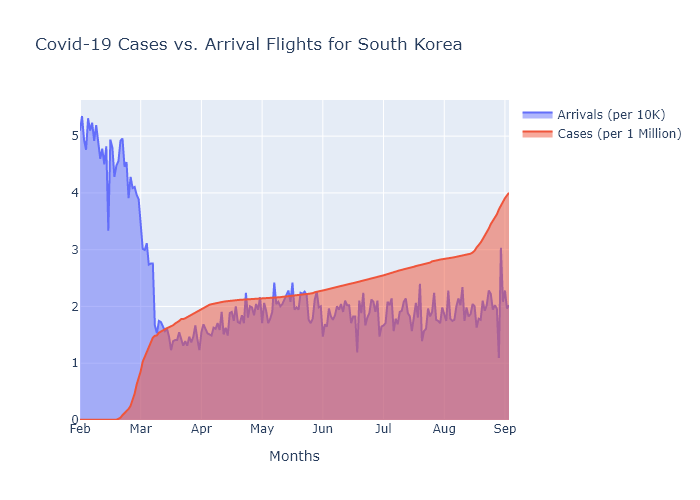

In [51]:
generate_usa_map(korea_x, korea_y, korea_flights_x)

In [49]:
def generate_usa_map(usa_x, usa_y, usa_flights_x):
    '''
    Given a date and the arrivals dictionary, produces what percent of US/Korea flew and the cases
    :param korea_x: date string
    :type korea_x: str
    :param korea_y: dictionary containing country arrival frequencies
    :type korea_y: dict
    :param korea_flights_x: dictionary containing country arrival frequencies
    :type korea_flights_x: dict
    :returns: generate plot for Korea map
    '''
    assert isinstance(korea_x, list)
    assert isinstance(korea_y, list)
    assert isinstance(korea_flights_x, list)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=usa_y, y=usa_flights_x, fill='tozeroy', name="Arrivals (per 10K)"))  # fill down to xaxis
    fig.add_trace(go.Scatter(x=usa_y, y=usa_x, fill='tozeroy', name="Cases (per 1 Million)"))  # fill to trace0 y

    fig.update_layout(
        xaxis_title="Months",
        title="Covid-19 Cases vs. Arrival Flights for United States",
        xaxis=dict(
            tickmode='array',
            tickvals=[0, 30, 60, 90, 120, 150, 180, 210],
            ticktext=['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
        )
    )
    fig.show()

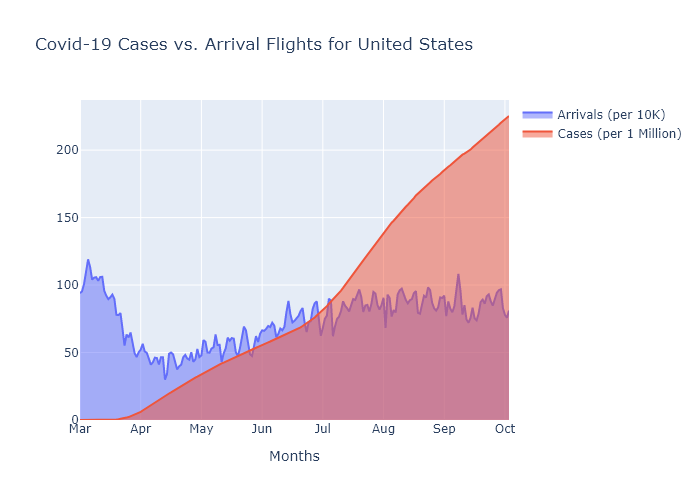

In [50]:
generate_usa_map(usa_x, korea_y, usa_flights_x)

In [21]:
def generate_flight_df(df):
    '''
    generate df with total flights by day as 2019 and 2020 columns
    :param df: the original dataframe
    :type df: pandas dataframe

    :returns: pandas df with flight daya
    '''

    # get daily flight frequencies
    assert isinstance(df, pd.DataFrame)
    d_counts = df['day'].value_counts().to_dict()

    # Order data by date
    od = collections.OrderedDict(sorted(d_counts.items()))
    newDict = dict()
    for key, value in od.items():
        if value > 20000:
            newDict[key] = value
    od = newDict

    # Using items() + len() + slice()
    # Split dictionary by half
    inc = iter(od.items())
    res1 = dict(islice(inc, 364))
    res2 = dict(inc)

    data_2019 = {}
    data_2020 = {}
    counter = 0
    for key, value in res1.items():
        data_2019[counter] = value
        counter += 1
    counter = 0
    for key, value in res2.items():
        data_2020[counter] = value
        counter += 1
    data = {'2019': data_2019, '2020': data_2020}
    df_flights = pd.DataFrame.from_dict(data).dropna()
    df_flights['2019'] = df_flights['2019'].rolling(7).mean()
    df_flights['2020'] = df_flights['2020'].rolling(7).mean()

    df_flights = df_flights.dropna()

    return df_flights

In [27]:
df_flights = generate_flight_df(df)

In [22]:
def generate_2019_2020_graph(df_flights):
    '''
    The dataframe containing flight data
    :param df: a pandas Dataframe containing all data
    :type df: pd.Dataframe

    :returns: Generates graph of total 2019 vs 2020 flights
    '''
    assert isinstance(df_flights, pd.DataFrame)
    fig = px.line(df_flights, x=df_flights.index, y=['2019', '2020'])
    fig.update_layout(
        xaxis_title="Months",
        yaxis_title="Number of Flights",
        legend_title="Year",
        title="Weekly Rolling Average of Daily Global Flights 2019 vs. 2020",
        xaxis = dict(
            tickmode = 'array',
            tickvals = [6, 36, 66, 96, 126, 156, 186, 216, 246, 276, 306, 336],
            ticktext = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        )
    )
    fig.show()

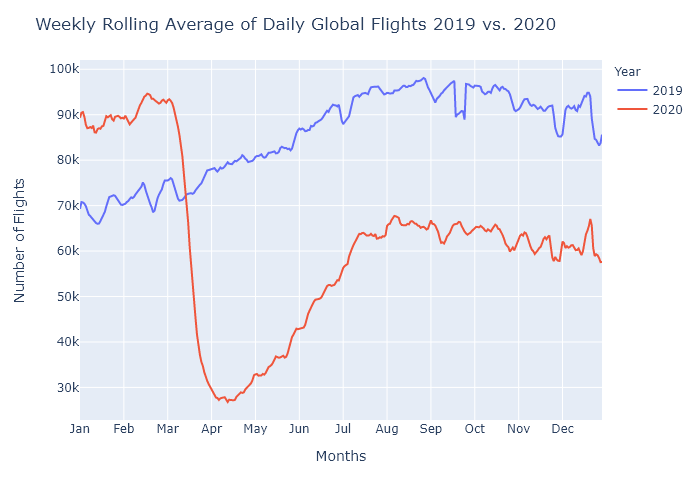

In [52]:
generate_2019_2020_graph(df_flights)